<a href="https://colab.research.google.com/github/ArtemF42/hse-fbb-ml-course-public/blob/main/seminars/08_intro_to_pytorch/intro_to_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Семинар.** Знакомство с PyTorch

In [1]:
from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

from IPython.display import clear_output

Подобно NumPy, библиотека PyTorch позволяет легко и удобно работать с многомерными массивами. В то же время существует ряд важных отличий:

* массивы мы теперь будем называть **тензорами** (наверное, это самое важное из них 😄);  

А также PyTorch:
* поддерживает вычисления на **GPU**;
* имеет встроенное **автоматическое дифференцирование**;
* содержит базовые блоки для построения **сложных нейронных сетей**.

**Примечание:** вообще у NumPy, Pandas и scikit-learn тоже есть GPU-аналоги — [CuPy](https://cupy.dev/), [cuDF](https://docs.rapids.ai/api/cudf/stable/), [cuML](https://docs.rapids.ai/api/cuml/stable/) и т.п. — но о них как-нибудь в другой раз (то есть никогда).


In [2]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
x

tensor([[1, 2, 3],
        [4, 5, 6]])

In [3]:
type(x)

torch.Tensor

Пожалуй, на этом и ограничимся, чтобы зря не тратить время. Скажем только, что почти у всего в NumPy есть свой аналог в PyTorch, и *vice versa*. Чаще всего они даже называются одинаково — например:

In [4]:
np.zeros(10)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [5]:
torch.zeros(10)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [6]:
np.arange(5, dtype=np.float32).mean()

np.float32(2.0)

In [7]:
torch.arange(5, dtype=torch.float32).mean()

tensor(2.)

Самое серьезное отличие, разумеется, заключается в том, что аргумент `axis` в PyTorch называется `dim`.

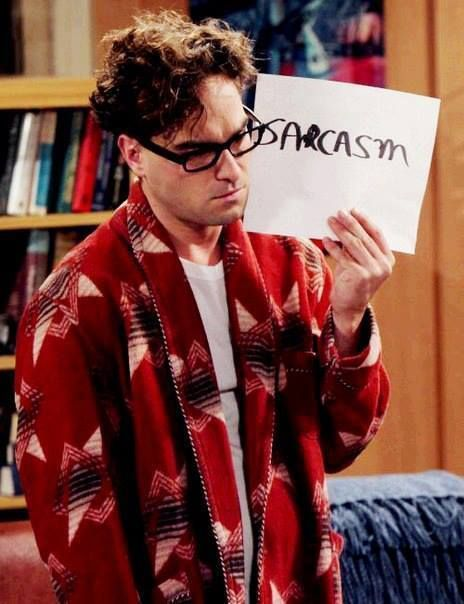

In [8]:
np.arange(12, dtype=np.float32).reshape(3, 4).mean(axis=1)

array([1.5, 5.5, 9.5], dtype=float32)

In [9]:
torch.arange(12, dtype=torch.float32).reshape(3, 4).mean(dim=1)

tensor([1.5000, 5.5000, 9.5000])

Но и здесь разработчики PyTorch спешат вам на помощь:

In [10]:
torch.arange(12, dtype=torch.float32).reshape(3, 4).mean(axis=1)

tensor([1.5000, 5.5000, 9.5000])

Хорошо-хорошо, мы поняли, что NumPy и PyTorch очень похожи. Кстати, `torch.Tensor` можно легко создать из `numpy.ndarray`.

In [11]:
a = np.arange(5)

In [12]:
b = torch.tensor(a)
c = torch.from_numpy(a)

Если вы используете `torch.from_numpy`, то PyTorch просто начинает ссылаться на тот же участок памяти, что и исходный массив. Такой способ работает значительно быстрее ...

In [13]:
%%timeit
torch.tensor(a)

10 µs ± 3.05 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [14]:
%%timeit
torch.from_numpy(a)

1.04 µs ± 13.3 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


 ... но имеет последствия.


In [15]:
a[2] = 9

print(f"{b = }")
print(f"{c = }")

b = tensor([0, 1, 2, 3, 4])
c = tensor([0, 1, 9, 3, 4])


Напоследок реализуем MSE — она нам пригодится чуточку позже.

In [16]:
def numpy_mse_loss(y_pred: np.ndarray, y_true: np.ndarray) -> np.ndarray:
    return np.square(y_true - y_pred).mean()


def torch_mse_loss(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    return torch.square(y_true - y_pred).mean()

In [17]:
y_true, y_pred = np.arange(5), np.ones(5)
numpy_mse_loss(y_pred, y_true)

np.float64(3.0)

In [18]:
y_true, y_pred = torch.arange(5), torch.ones(5)
torch_mse_loss(y_pred, y_true)

tensor(3.)

Иными словами, все, что можно было написать на NumPy, с тем же успехом можно сделать и с помощью PyTorch.

### Ускорение вычислений при помощи GPU

Теперь давайте немного поговорим о **CPU** и **GPU**. Что это вообще такое?  

- **CPU** — это *Central Processing Unit*, то есть то, что обычно называют процессором. Он умеет выполнять сложные операции, но его вычислительные ресурсы ограничены.

- Напротив, **GPU**, или *Graphical Processing Unit*, (графический процессор, а совсем по-простому — видеокарта) выполняет относительно простые операции, но умеет делать это параллельно, за счет чего значительно сокращает время вычислений.

В процессе обучения нейронных сетей мы обычно выполняем множество простых операций, например, при умножении матриц, поэтому использование **GPU** может существенно снизить время обучения.

Давайте это проверим.

In [19]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [20]:
A = torch.randn((1_000, 2_000))
B = torch.randn((2_000, 3_000))

In [21]:
%%timeit
A @ B

105 ms ± 24.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
A = A.to(DEVICE)  # Перенос уже существующего тензора на девайс
B = torch.randn((2_000, 3_000), device=DEVICE)  # Создание нового

In [23]:
%%timeit
A @ B

3.88 ms ± 295 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Есть только одна маленькая проблемка — объем памяти графического ускорителя значительно меньше, поэтому отныне `RuntimeError: CUDA out of memory` будет вашим верным спутником.

### Автоматическое дифференцирование

Мы с вами уже знаем, как обучать простые модели машинного обучения методом градиентного спуска, и даже считали градиенты вручную. Но что делать, если мы обучаем большую нейронную сеть? Здесь на сцену выходит **автоматическое дифференцирование**.  

У тензоров в PyTorch есть атрибут `requires_grad`, который по умолчанию равен `False`. Кроме того, для всех базовых операций заранее определены производные. А сложные операции — это всего лишь комбинации простых, поэтому мы можем воспользоваться правилом дифференцирования сложных функций. Остается только запомнить порядок вычислений — и определить значения градиентов уже не составит никакого труда.


In [24]:
x = torch.randn(3)
x.requires_grad

False

In [25]:
x = torch.arange(3, dtype=torch.float32, requires_grad=True)
x

tensor([0., 1., 2.], requires_grad=True)

In [26]:
y = torch.square(x).sum()
y

tensor(5., grad_fn=<SumBackward0>)

In [27]:
y.backward()

In [28]:
x.grad

tensor([0., 2., 4.])

### Работа с данными

Отдохнем немного от PyTorch и вернемся ненадолго к нашим старым друзьям.

In [29]:
data = pd.read_csv("data.csv", index_col="id")
print(f"{data.shape = }")
data.head()

data.shape = (750000, 8)


,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
id,,,,,,,,
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [30]:
data.isna().sum()

,0
Sex,0
Age,0
Height,0
Weight,0
Duration,0
Heart_Rate,0
Body_Temp,0
Calories,0


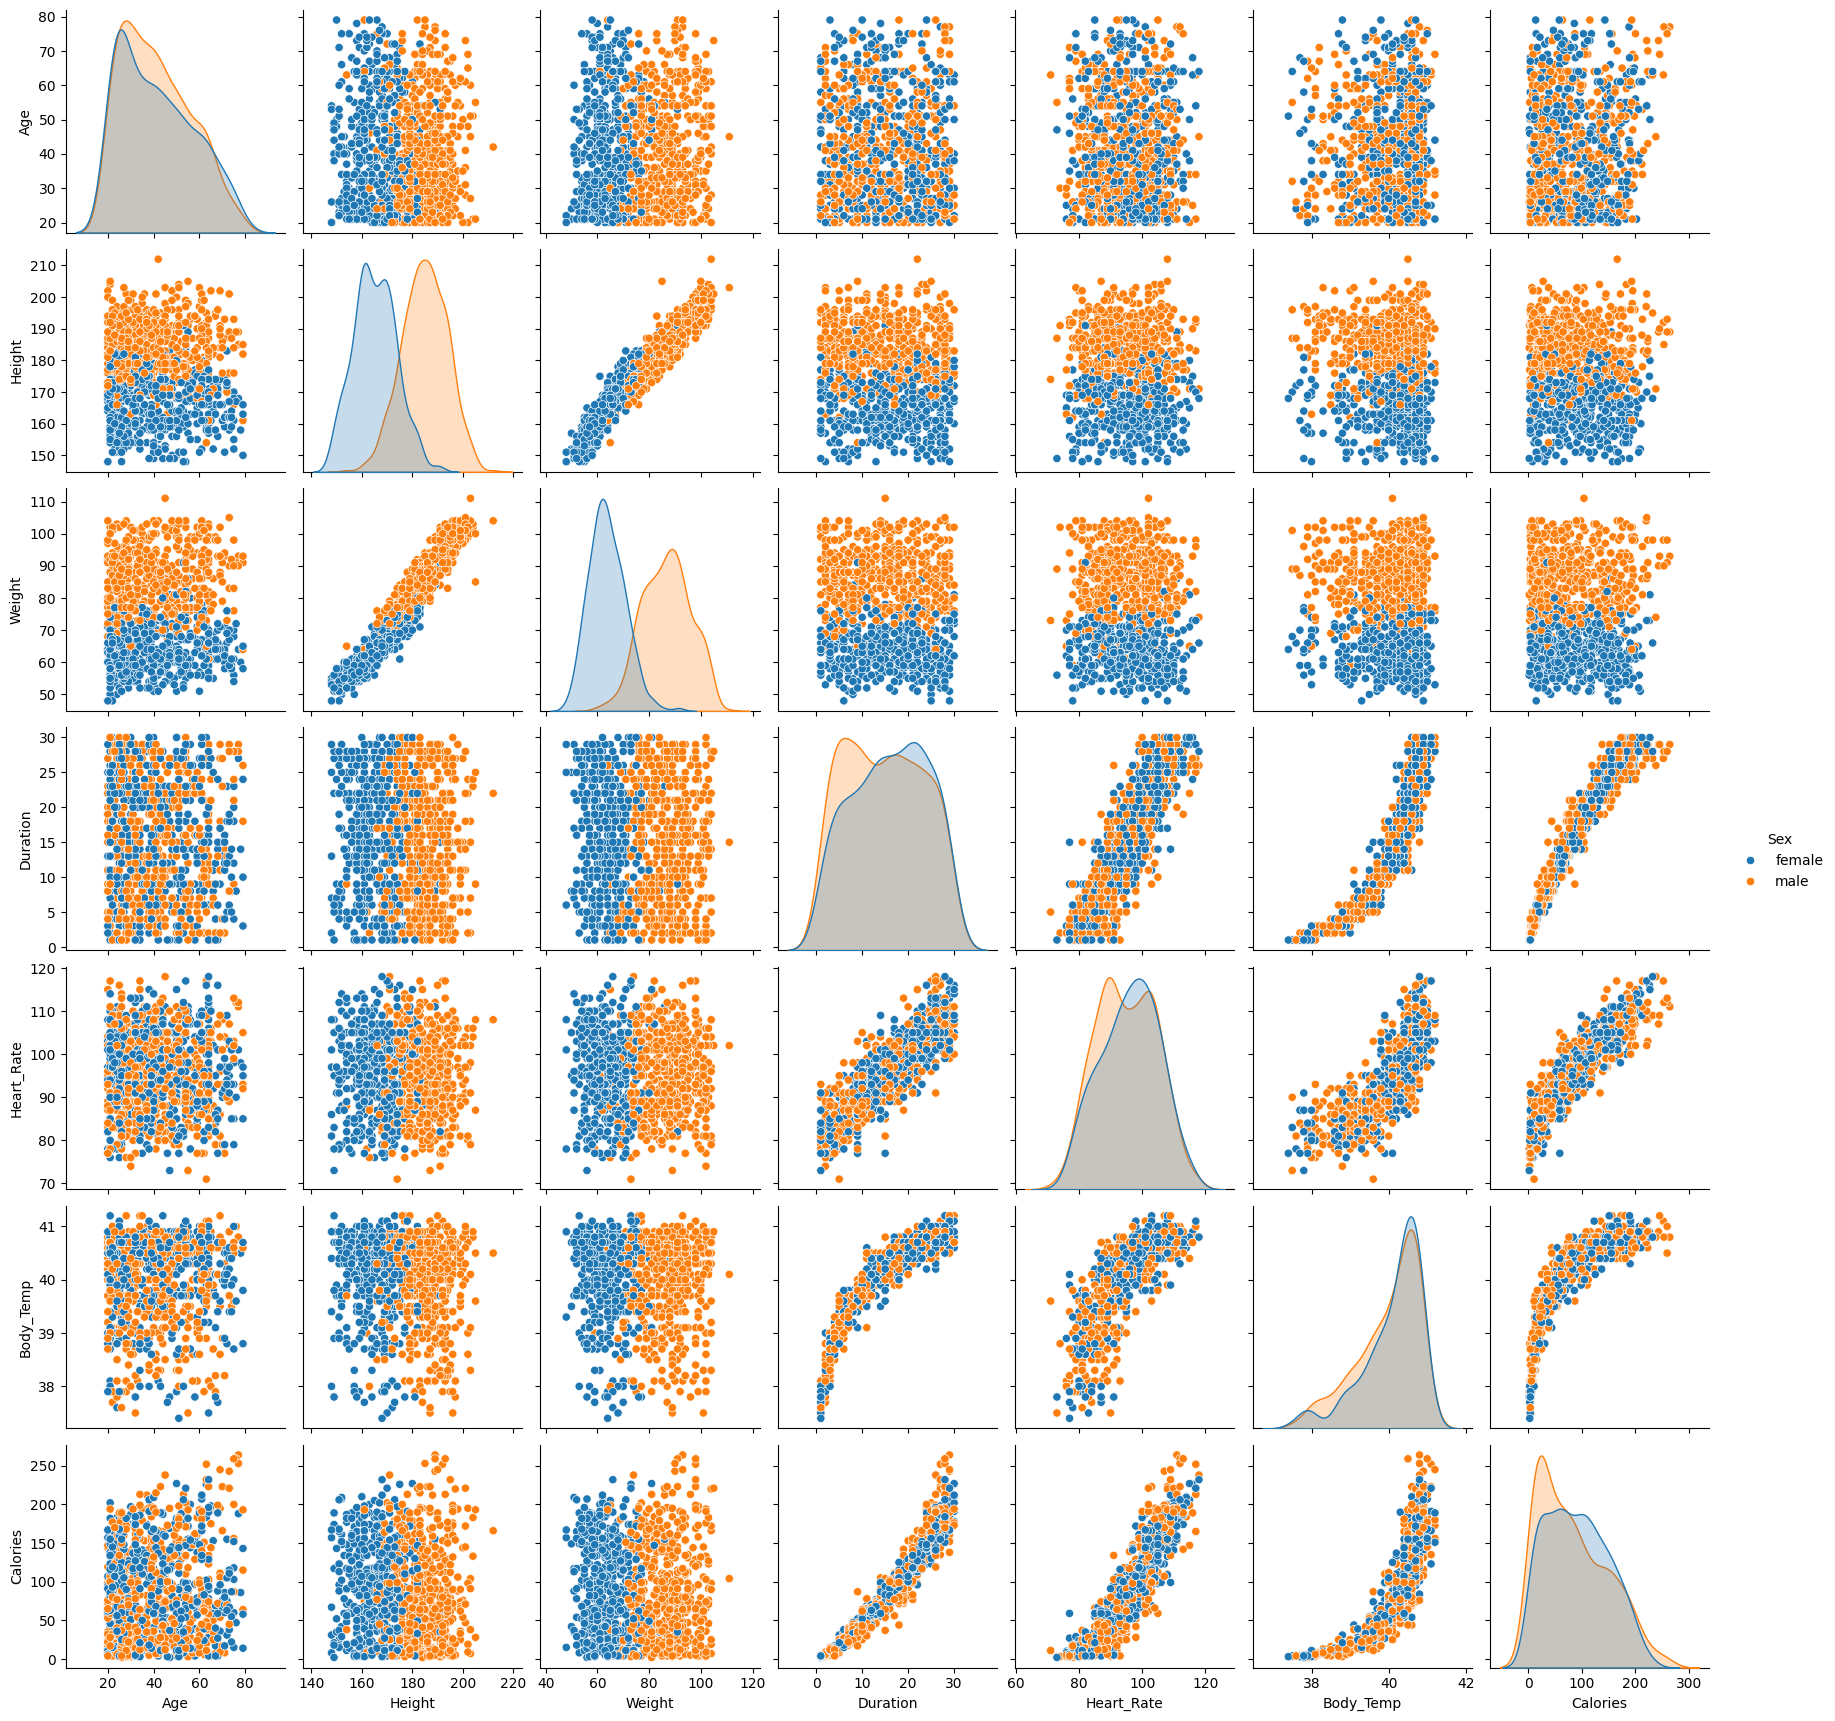

In [31]:
sns.pairplot(data.sample(1_000, random_state=42), hue="Sex")

In [32]:
X, y = data.drop(columns="Calories"), data["Calories"].values

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=42)

print(f"{y_train_val.size = }")
print(f"{y_test.size = }")

y_train_val.size = 562500
y_test.size = 187500


In [33]:
CATEGORICAL_FEATURES = ["Sex"]
NUMERICAL_FEATURES = X.columns.difference(CATEGORICAL_FEATURES).to_list()

column_transformer = ColumnTransformer(
    transformers=[
        ("one_hot_encoder", OneHotEncoder(), CATEGORICAL_FEATURES),
        ("robust_scaler", RobustScaler(), NUMERICAL_FEATURES),
    ]
)

X_train_val = column_transformer.fit_transform(X_train_val)
X_test = column_transformer.transform(X_test)

In [34]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val)

In [35]:
model = LinearRegression().fit(X_train_val, y_train_val)

y_pred = model.predict(X_test)
print(f"MAPE:\t{mean_absolute_percentage_error(y_test, y_pred) * 100:.3f}")

MAPE:	28.883


Так себе модель, конечно, но что-то мы увлеклись... Вернемся к PyTorch.

In [36]:
X_train_val = torch.tensor(X_train_val, dtype=torch.float32)
y_train_val = torch.tensor(y_train_val, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

Для работы с данными в PyTorch существуют два основных класса — `Dataset` и `DataLoader`.
Первый отвечает за хранение данных, а второй — за их упаковку в батчи и подачу в модель.

Если вы пишете свой собственный датасет, он должен наследоваться от класса `torch.utils.data.Dataset` и содержать три метода:

- `__init__` — инициализирует новый датасет;
- `__getitem__` — возвращает объект по индексу;
- `__len__` — возвращает количество объектов в датасете.

Давайте один такой и напишем.

In [37]:
class SimpleDataset(Dataset):
    def __init__(self, X: torch.Tensor, y: torch.Tensor) -> None:
        super().__init__()

        self.X = X
        self.y = y

    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        return self.X[index], self.y[index]

    def __len__(self) -> int:
        return self.X.shape[0]

In [38]:
train_val_dataset = SimpleDataset(X_train_val, y_train_val)

In [39]:
train_val_dataset[42]

(tensor([ 0.0000,  1.0000, -0.7500, -0.3636, -0.4000, -0.4000,  0.7143,  0.8333]),
 tensor(30.))

In [40]:
len(train_val_dataset)

562500

Куда же без разбиения данных — для этого пригодится функция `random_split`.

In [41]:
train_dataset, val_dataset = random_split(train_val_dataset, lengths=(0.8, 0.2))

len(train_dataset), len(val_dataset)

(450000, 112500)

Наши данные — это всего лишь два тензора. Для такого формата в PyTorch уже существует готовый класс — `TensorDataset`. Теперь воспользуемся им.

In [42]:
test_dataset = TensorDataset(X_test, y_test)

In [43]:
test_dataset[451]

(tensor([ 1.0000,  0.0000, -0.7500,  0.0909,  0.2000,  0.2667, -0.5238, -0.5833]),
 tensor(94.))

`DataLoader` собирает несколько элементов датасета в один большой батч, который затем передаётся в модель.
Его основные параметры включают:

* `dataset` — сам датасет, данные из которого нужно собирать;
* `batch_size` — размер батча (количество элементов в нём);
* `shuffle` — нужно ли перемешивать данные.

О других полезных параметрах, например `num_workers` и `collate_fn`, можно прочитать в [документации](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).


In [44]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=512)
test_dataloader = DataLoader(test_dataset, batch_size=512)

In [45]:
for batch in train_dataloader:
    break

print(f"{type(batch) = }")

print(f"{batch[0].shape = }")
print(f"{batch[1].shape = }")

type(batch) = <class 'list'>
batch[0].shape = torch.Size([256, 8])
batch[1].shape = torch.Size([256])


### Нейронные сети (ну, почти)

Теперь поговорим о том, как создавать нейронные сети. В некотором смысле этот процесс напоминает сборку LEGO — вам дан набор базовых блоков, которые нужно правильно скомбинировать, чтобы получить нейронную сеть. Все эти блоки лежат в модуле `torch.nn`. Самый главный из них — `nn.Module`, от которого должны наследоваться все остальные (в том числе и ваши).

Начнем мы с **линейного слоя** — `nn.Linear`, и с его помощью напишем **линейную регрессию**. Каждая нейронная сеть должна наследоваться от класса `nn.Module` и иметь как минимум два метода: `__init__` и `forward`. В первом описываются блоки модели, а во втором — то, как они применяются для преобразования входных данных.

In [46]:
class LinearRegression(nn.Module):
    def __init__(self, in_dim: int, out_dim: int) -> None:
        super().__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim

        self.linear = nn.Linear(in_dim, out_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear(x)

In [47]:
model = LinearRegression(8, 1)
model(batch[0]).shape

torch.Size([256, 1])

Еще один пример — многослойный перцептрон:

In [48]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, hidden_dim: Optional[int] = None) -> None:
        super().__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim

        if hidden_dim is None:
            hidden_dim = in_dim * 4

        self.layers = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

А вот так выглядит U-Net — архитектура для сегментации изображений. Блоки другие, но конструктор все тот же.

In [49]:
class UNetConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)


class UNet(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()

        self.conv1 = UNetConv(in_channels, 64)
        self.conv2 = UNetConv(64, 128)
        self.conv3 = UNetConv(128, 256)
        self.conv4 = UNetConv(256, 512)
        self.conv5 = UNetConv(512, 1024)

        self.conv6 = UNetConv(1024, 512)
        self.conv7 = UNetConv(512, 256)
        self.conv8 = UNetConv(256, 128)
        self.conv9 = UNetConv(128, 64)

        self.deconv1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.deconv2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.deconv3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.deconv4 = nn.ConvTranspose2d(128, 64, 2, stride=2)

        self.outconv = nn.Conv2d(64, out_channels, 1)
        self.maxpool = nn.MaxPool2d(2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = self.conv1(x)
        x2 = self.conv2(self.maxpool(x1))
        x3 = self.conv3(self.maxpool(x2))
        x4 = self.conv4(self.maxpool(x3))

        x = self.conv5(self.maxpool(x4))
        x = self.conv6(torch.cat((self.deconv1(x), x4), dim=1))
        x = self.conv7(torch.cat((self.deconv2(x), x3), dim=1))
        x = self.conv8(torch.cat((self.deconv3(x), x2), dim=1))
        x = self.conv9(torch.cat((self.deconv4(x), x1), dim=1))

        return self.sigmoid(self.outconv(x))

### Обучение модели

Наконец, мы готовы обучить нашу модель. В этом нам поможет **цикл обучения**.

План такой:

1. берем один батч;
2. пропускаем входные данные через `forward` модели;
3. считаем значение функции потерь;
4. вызываем `backward`.

Последнее недостающее звено — **оптимизатор**. Он использует градиенты для обновления весов модели.

5. обновляем веса при помощи оптимизатора;
6. повторяем, пока не надоест (а точнее — пока не решим остановиться).

Кроме того, мы можем добавить подсчет качества модели на валидационной подвыборке, отслеживание значений функции потерь и метрик — и многое другое.


In [50]:
NUM_EPOCHS = 25

model = LinearRegression(8, 1).to(DEVICE)
# model = MultilayerPerceptron(8, 1).to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

train_loss_history: list[float] = []
val_loss_history: list[float] = []

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss: list[float] = []

    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch} — Training", leave=False):
        x, y_true = map(lambda t: t.to(DEVICE), batch)
        y_pred = model(x).squeeze()

        loss = torch_mse_loss(y_pred, y_true)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        train_loss.append(loss.item())

    train_epoch_loss: float = sum(train_loss) / len(train_loss)
    train_loss_history.append(train_epoch_loss)

    model.eval()
    val_loss: list[float] = []

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f"Epoch {epoch} — Validation", leave=False):
            x, y_true = map(lambda t: t.to(DEVICE), batch)
            y_pred = model(x).squeeze(-1)

            loss = torch_mse_loss(y_pred, y_true)
            val_loss.append(loss.item())

    val_epoch_loss: float = sum(val_loss) / len(val_loss)
    val_loss_history.append(val_epoch_loss)

    clear_output(wait=True)
    print(f"[{epoch:03d}/{NUM_EPOCHS}] train={train_epoch_loss:.4f} | val={val_epoch_loss:.4f}")

[024/25] train=124.6548 | val=125.8723


**Примечание**

В данном примере в качестве функции потерь мы использовали ранее написанную функцию `torch_mse_loss`. С той же целью можно использовать уже имеющиеся в PyTorch функции потерь. Они также расположены в модуле `nn`, например: `nn.MSELoss`, `nn.CrossEntropyLoss`, `nn.BCELoss`.


In [51]:
y_true, y_pred = torch.arange(5), torch.ones(5)

In [52]:
loss_fn = nn.MSELoss()
loss_fn(y_pred, y_true)

tensor(3.)

Более того, в модуле `nn` есть подмодуль `nn.functional`, в котором находятся версии тех же “деталей LEGO”, но уже в виде обычных функций.


In [53]:
nn.functional.mse_loss(y_pred, y_true)

tensor(3.)

### Инференс модели

Наконец, пришло время для предсказаний. Здесь мы познакомимся еще с двумя важными моментами:

* Во-первых, вновь используем контекстный менеджер `with torch.no_grad()`, поскольку градиенты нам больше не нужны.
* Во-вторых, нам нужно сохранять предсказания, но изначально они находятся на GPU. Если не освобождать память, то очень быстро можно столкнуться `CUDA out of memory`, поэтому готовые предсказания следует переносить обратно на CPU.


In [54]:
model = model.eval()

y_pred: list[torch.Tensor] = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Inference"):
        x, y_true = map(lambda t: t.to(DEVICE), batch)
        y_pred.append(model(x).squeeze().cpu())

y_pred = torch.cat(y_pred)

Inference: 100%|██████████| 367/367 [00:01<00:00, 213.51it/s]


In [55]:
mape = ((y_test - y_pred) / y_test).abs().mean() * 100
print(f"MAPE:\t{mape:.3f}")

MAPE:	30.334
